In [266]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.spatial
import scipy.optimize as opt
import pyro.contrib.gp as gp
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.spatial
from scipy.stats import norm
import scipy.optimize as opt
import math

In [267]:
def gaussian_kernel(X,Xprime, gamma=2):
    dists = scipy.spatial.distance.cdist(X[:, np.newaxis],Xprime[:, np.newaxis],metric='sqeuclidean')
    return np.exp(-gamma*dists)

def special_kernel(X,Xprime, eta):
    a, b = eta
    K = 1/2*(X@Xprime.T) + a * np.multiply.outer(np.sin(2*6*np.pi*X.reshape(-1)+b),np.sin(2*6*np.pi*Xprime.reshape(-1)+b))
    return K

def matern_kernel(X, Xprime, eta):
    var, l = eta
    sqrt3_r = np.sqrt(3) * (np.abs(X - Xprime)/l)
    return var * (1 + sqrt3_r) * np.exp(-sqrt3_r)

In [268]:
seed = 42
random_state = np.random.default_rng(seed)

In [269]:
def sample_datapoints(g, mu, std, x):
    epsilon = norm.rvs(loc=mu, scale=std, size=x.shape[0], random_state=random_state)
    return g(x) + epsilon

In [270]:
def g(x):
    #return x
    return - np.sin(6 * math.pi * x) ** 2 + 6*x ** 2 - 5*x ** 4 + 1.5

In [271]:
l = 101

X = np.array([(i-1)/(l-1) for i in range (1, l + 1)])
y = sample_datapoints(g, 0, 0.01, X)


In [272]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=10./30., random_state=seed)

print("Train Data:", X_train)
print("Test Data:", X_test)  

Train Data: [0.83 0.05 0.47 0.53 0.35 0.16 0.81 0.34 0.07 0.43 0.73 0.27 0.19 0.94
 0.25 0.62 0.49 0.13 0.24 0.03 0.17 0.38 0.08 0.79 0.06 0.65 0.36 0.88
 0.56 1.   0.54 0.5  0.68 0.46 0.69 0.61 0.98 0.8  0.41 0.58 0.48 0.9
 0.57 0.75 0.32 0.95 0.59 0.63 0.85 0.37 0.29 0.01 0.52 0.21 0.02 0.23
 0.87 0.99 0.74 0.86 0.82 0.2  0.6  0.71 0.14 0.92 0.51]
Test Data: [0.84 0.55 0.66 0.67 0.45 0.39 0.22 0.44 0.1  0.   0.18 0.3  0.97 0.33
 0.77 0.04 0.93 0.78 0.12 0.31 0.76 0.89 0.26 0.42 0.7  0.15 0.4  0.72
 0.09 0.96 0.11 0.91 0.64 0.28]


[0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.005]


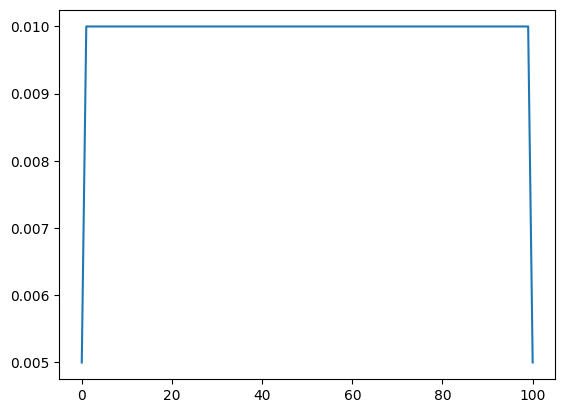

In [273]:
w = np.ones(l) * 1/(l-1)
w[0] = 1/(2*(l - 1))    
w[-1] = 1/(2*(l - 1)) 

print(w)
plt.plot(w)

In [274]:
def conditional(X, kernel, kernel_param, w, q_hat):
    K = kernel(X, X, kernel_param)
    
    wKw = w.T @ K @ w
    # mean
    mu_cond = (K @ w) * (q_hat / wKw)
    # cov
    Sigma_cond = K - np.outer(K @ w, K @ w) / wKw
    return mu_cond, Sigma_cond

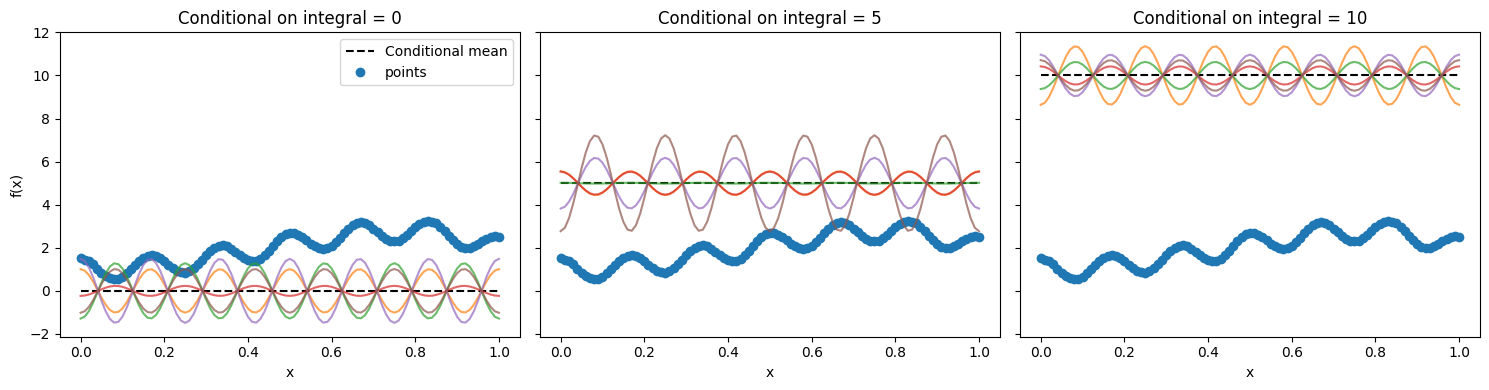

In [275]:
q_values = [0, 5, 10]

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
for ax, q_val in zip(axes, q_values):

    mu_q, Sigma_q = conditional(X, special_kernel, (1.074, np.pi/2), w, q_val)
    jitter = 1e-10

    L = np.linalg.cholesky(Sigma_q + jitter * np.eye(l))
    
    n_samples = 5
    f_samples = []
    for _ in range(n_samples):
        z = np.random.randn(l)  # standard normal
        f_sample = mu_q + L @ z
        f_samples.append(f_sample)
    
    # Plot
    ax.plot(X, mu_q, 'k--', label='Conditional mean')
    ax.plot(X, y,'o', label="points")
    for fs in f_samples:
        ax.plot(X, fs, alpha=0.7)
    ax.set_title(f'Conditional on integral = {q_val}')
    ax.set_xlabel('x')
    
axes[0].set_ylabel('f(x)')
axes[0].legend()
plt.tight_layout()
plt.show()